## Name - Kshitij Ajaykumar Patel

## GitHub - kapatel20

## USC ID - 1663106670

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from sklearn.utils import resample
from scipy.stats import bootstrap
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV, chi2
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from prettytable import PrettyTable
import warnings
import time
from sklearn.metrics import roc_curve, roc_auc_score,RocCurveDisplay
warnings.filterwarnings('ignore')

# Task - 1

## Part - 1a, 1b:

In [2]:
train_folder = []
test_folder = []
folder = {}

path = "../data/AReM/"
activities = os.listdir("../data/AReM/")
activity_files_dict = {}

cnt=0
for activity in activities:
    path_activity = path+activity+"/"
    
    if activity[-3:]=="pdf":
        continue
    
    if activity not in folder:
        folder[activity] = []
    
    files = os.listdir(path_activity)
    activity_files_dict[activity] = len(files)
    
    for file in files:
        folder[activity].append(path+activity+"/"+file)
        
        if (file == "dataset1.csv" or file == "dataset2.csv") and (activity == "bending1" or activity == "bending2"):
            test_folder.append(path+activity+"/"+file)
            continue
        elif (file == "dataset1.csv" or file == "dataset2.csv" or file == "dataset3.csv") and (activity == "cycling" or activity == "lying" or activity == "sitting" or activity == "standing" or activity == "walking"):
            test_folder.append(path+activity+"/"+file)
            continue
        else:
            train_folder.append(path+activity+"/"+file)

## Part - 1C - i

### Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

<ul>
<li>maximum</li>
<li>minimum</li>
<li>mean</li>
<li>median</li>
<li>standard deviation</li>
<li>first quartile</li>
<li>third quartile</li>
<li>stationarity</li>
<li>entropy</li>
<li>distribution</li>
<li>scaling properties</li>
<li>correlation structure</li>
</ul>

## Part - 1C - ii

### Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [3]:
features = ["min","max","mean","median","std","1st Quart","3rd Quart"]
table_col = []

for i in range(1,7):
    for feature in features:    
        table_col.append(feature+str(i))
table_col.append("label")

In [4]:
dataset = pd.DataFrame(columns=table_col)
cnt_total = 1

for activity in activity_files_dict:
    for i in range(1,activity_files_dict[activity]+1):
        df = pd.read_csv(path+activity+"/"+"dataset"+str(i)+".csv",skiprows=4)
        df_des = df.describe()
        df_col = list(df.columns)
        temp_row = []
            
        for col in df_col:
            for feature in features:    
                if col=="# Columns: time":
                    continue
                if feature=="median":
                    temp_row.append(np.median(df[col].values))
                    continue
                if feature=="1st Quart":
                    temp_row.append(df_des[col]["25%"])
                    continue
                if feature=="3rd Quart":
                    temp_row.append(df_des[col]["75%"])
                    continue
                temp_row.append(df_des[col][feature])
        temp_row.append(activity)
        dataset.loc[len(dataset.index)] = temp_row    

In [5]:
dataset.index+=1
dataset

,min1,max1,mean1,median1,std1,1st Quart1,3rd Quart1,min2,max2,mean2,...,1st Quart5,3rd Quart5,min6,max6,mean6,median6,std6,1st Quart6,3rd Quart6,label
1,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,33.0000,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,bending1
2,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372437,...,32.0000,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,bending1
3,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,bending1
4,33.00,47.75,42.179812,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,bending1
5,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,walking
85,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,13.5000,17.75,0.00,9.67,3.432563,3.20,1.732727,2.1575,4.5650,walking
86,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,walking
87,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,walking


## Part - 1C - iii

### Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [6]:
std_dataset = PrettyTable(["Column", "Standard Deviation"])
for col in dataset.columns:
    if col == "label":
        continue
    std_dataset.add_row([col, dataset[col].std()])

#### ---> Standard Devaition for each of the time-domain features

In [7]:
print(std_dataset)

+------------+----------------------+
|   Column   |  Standard Deviation  |
+------------+----------------------+
|    min1    |  9.569975284512807   |
|    max1    |   4.39436168470319   |
|   mean1    |  5.335717658344174   |
|  median1   |  5.440054137152637   |
|    std1    |  1.7721533975028398  |
| 1st Quart1 |  6.1535897241853705  |
| 3rd Quart1 |  5.138924613450999   |
|    min2    |         0.0          |
|    max2    |  5.0627293748106394  |
|   mean2    |  1.5741639200745141  |
|  median2   |  1.4122441649745634  |
|    std2    |  0.8841054781862713  |
| 1st Quart2 |  0.9463861911256928  |
| 3rd Quart2 |   2.12526640640591   |
|    min3    |  2.956462059205819   |
|    max3    |  4.875136693954744   |
|   mean3    |  4.008380131777648   |
|  median3   |  4.036396318784075   |
|    std3    |  0.9467102620752955  |
| 1st Quart3 |   4.22065788450763   |
| 3rd Quart3 |  4.171628224016796   |
|    min4    |         0.0          |
|    max4    |  2.1836254849723407  |
|   mean4   

#### ---> 90% Bootstrap Confidence Interval for Standard Deviation of the features

In [8]:
rng = np.random.default_rng()
data = (dataset.drop(["label"],axis=1),)
res = bootstrap(data, np.std, confidence_level=0.9, random_state=1)

In [9]:
df_conf_interval = pd.DataFrame(data={'low':res.confidence_interval.low,'high':res.confidence_interval.high},index=list(dataset.drop(["label"],axis=1).columns))

In [10]:
df_conf_interval.fillna(0)

,low,high
min1,8.527952,11.198260
max1,3.522045,5.524057
mean1,4.793516,5.982295
median1,4.876540,6.106719
std1,1.600446,1.988932
1st Quart1,5.646629,6.729899
3rd Quart1,4.454625,5.977600
min2,0.000000,0.000000
max2,4.677428,5.443731
mean2,1.413146,1.709863


## Part - 1C - iv

### Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

In [11]:
def labelEnc(x):
    if x == "bending1" or x == "bending2":
        return 1
    return 0

dataset["Enc_Label"] = dataset["label"].apply(labelEnc)

In [12]:
dataset

,min1,max1,mean1,median1,std1,1st Quart1,3rd Quart1,min2,max2,mean2,...,3rd Quart5,min6,max6,mean6,median6,std6,1st Quart6,3rd Quart6,label,Enc_Label
1,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,bending1,1
2,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372437,...,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,bending1,1
3,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,bending1,1
4,33.00,47.75,42.179812,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,bending1,1
5,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,bending1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,walking,0
85,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,17.75,0.00,9.67,3.432563,3.20,1.732727,2.1575,4.5650,walking,0
86,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,walking,0
87,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,walking,0


In [13]:
model = LogisticRegression()
model.fit(dataset.drop(["label","Enc_Label"],axis=1), dataset["Enc_Label"])

LogisticRegression()

In [14]:
coef_df = pd.DataFrame(columns=dataset.drop(["label","Enc_Label"],axis=1).columns)

In [15]:
coef_df.loc[len(coef_df)] = model.coef_[0]

In [16]:
coef_df

,min1,max1,mean1,median1,std1,1st Quart1,3rd Quart1,min2,max2,mean2,...,std5,1st Quart5,3rd Quart5,min6,max6,mean6,median6,std6,1st Quart6,3rd Quart6
0,-0.144354,0.066434,-0.106392,-0.039113,-0.033043,-0.039367,-0.237683,0.0,-0.255083,-0.075363,...,0.017551,0.202646,0.165011,-0.000013,-0.141746,-0.078958,-0.072695,-0.043272,-0.056967,-0.10557


In [17]:
coef_estimates = {}
coef_estimates["min"] = (np.abs(coef_df["min1"][0])+np.abs(coef_df["min2"][0])+np.abs(coef_df["min3"][0])+np.abs(coef_df["min4"][0])+np.abs(coef_df["min5"][0])+np.abs(coef_df["min6"][0]))/6
coef_estimates["max"] = (np.abs(coef_df["max1"][0])+np.abs(coef_df["max2"][0])+np.abs(coef_df["max3"][0])+np.abs(coef_df["max4"][0])+np.abs(coef_df["max5"][0])+np.abs(coef_df["max6"][0]))/6
coef_estimates["mean"] = (np.abs(coef_df["mean1"][0])+np.abs(coef_df["mean2"][0])+np.abs(coef_df["mean3"][0])+np.abs(coef_df["mean4"][0])+np.abs(coef_df["mean5"][0])+np.abs(coef_df["mean6"][0]))/6
coef_estimates["median"] = (np.abs(coef_df["median1"][0])+np.abs(coef_df["median2"][0])+np.abs(coef_df["median3"][0])+np.abs(coef_df["median4"][0])+np.abs(coef_df["median5"][0])+np.abs(coef_df["median6"][0]))/6
coef_estimates["std"] = (np.abs(coef_df["std1"][0])+np.abs(coef_df["std2"][0])+np.abs(coef_df["std3"][0])+np.abs(coef_df["std4"][0])+np.abs(coef_df["std5"][0])+np.abs(coef_df["std6"][0]))/6
coef_estimates["1st Quart"] = (np.abs(coef_df["1st Quart1"][0])+np.abs(coef_df["1st Quart2"][0])+np.abs(coef_df["1st Quart3"][0])+np.abs(coef_df["1st Quart4"][0])+np.abs(coef_df["1st Quart5"][0])+np.abs(coef_df["1st Quart6"][0]))/6
coef_estimates["3rd Quart"] = (np.abs(coef_df["3rd Quart1"][0])+np.abs(coef_df["3rd Quart2"][0])+np.abs(coef_df["3rd Quart3"][0])+np.abs(coef_df["3rd Quart4"][0])+np.abs(coef_df["3rd Quart5"][0])+np.abs(coef_df["3rd Quart6"][0]))/6


In [18]:
coef_estimates

{'min': 0.1019130557595611,
 'max': 0.19646874738930564,
 'mean': 0.10773268855030753,
 'median': 0.087075188886579,
 'std': 0.027837825242116827,
 '1st Quart': 0.07653410777936516,
 '3rd Quart': 0.1425532728060029}

#### From the above tables and values, "min" does not look to be a good feature as its std is 0. Also from the average coefficient values of the Logistic Regression model trained for the task mentioned in HW4, it can be seen that max, 3rd Quartile and mean are the three most important values. As the coefficients of the model represent  the change in the target variable associated with a one-unit change in the corresponding feature, while holding all other features constant. 

# Task - 2 

## ISLR 3.7.4

<b> A) Suppose that the true relationship between X and Y is linear,
i.e. Y = β0 + β1X + ϵ. Consider the training residual sum of
squares (RSS) for the linear regression, and also the training
RSS for the cubic regression. Would we expect one to be lower
than the other, would we expect them to be the same, or is there
not enough information to tell? Justify your answer.</b>

<i>Ans. </i> If the true relationship between X and Y is linear then we would expect the RSS for Cubic regression to be smaller than that for the linear regression. As the relationship is linear, the cubic regression will have more flexiblity than the linear regression because of the polynomial terms and hence it will also capture the noise in the training data leading to small RSS value in training data when compared to linear regression.

<b> B) Answer (a) using test rather than training RSS</b>

<i>Ans. </i> If true relationship between X and Y is linear then we would expect RSS for linear regression to be smaller than that of cubic regression. It is because the linear regression model is not as flexible as cubic regression, leading to generalize well on unseen test data when compared to cubic regression.

<b>C. Suppose that the true relationship between X and Y is not linear,
but we don’t know how far it is from linear. Consider the training
RSS for the linear regression, and also the training RSS for the
cubic regression. Would we expect one to be lower than the
other, would we expect them to be the same, or is there not
enough information to tell? Justify your answer.</b>

<i>Ans. </i>If the true relationship between X and Y is not linear then training RSS for cubic regression will have smaller values compared to linear regression. As cubic regression is more flexible it will tune to the noise in the dataset.

<b> D) Answer (c) using test rather than training RSS</b>

<i> Ans. </i> If true relationship between X and Y is not linear then we do not have enough information to tell which has smaller value. If non-linearlity is large then cubic regression will perform better as it has more flexiblity than linear regression. If non-linearity is very small then linear regression will generalize better than cubic and hence it will have smaller RSS value.

<h1 align="center"> Time Series Classification Part - 2</h1>

In [19]:
# Function to return Column Names for DataFrame for different values of L
def col_names(k,scatter=False):
    feat = ["max","mean","3rd Quart"]
    if scatter:
        col=[1,2,6]
    else:
        col = [1,2,3,4,5,6]
    column_names = []
    for f in feat:
        for i in range(1,k+1):
            for c in col:
                column_names.append(f+str(c)+"_"+str(i))
    return column_names
        

In [20]:
# prepareData -> Function to create different dataset for different values of L
def prepareData(folder,k,scatter=False):
    cols = col_names(k,scatter)
    cols.append("label")
    final_dataset_list = []
    for file in folder:
        temp_df = pd.read_csv(file,skiprows=4)
        label_v = file.split("/")[3]
        splits = np.array_split(temp_df,k)
        data_list = []
        for i in range(len(splits)):
            if scatter:
                data_list.extend(splits[i].iloc[:,[1,2,6]].max())
                continue
            data_list.extend(splits[i].iloc[:,1:].max())      

        for i in range(len(splits)):
            if scatter:
                data_list.extend(splits[i].iloc[:,[1,2,6]].mean())
                continue
            data_list.extend(splits[i].iloc[:,1:].mean())

        for i in range(len(splits)):
            if scatter:
                data_list.extend(splits[i].iloc[:,[1,2,6]].quantile(0.75))
                continue
            data_list.extend(splits[i].iloc[:,1:].quantile(0.75))
        if label_v=="bending1" or label_v=="bending2":
            data_list.append(1)
        else:
            data_list.append(0)
        final_dataset_list.append(data_list)
    final_dataset = pd.DataFrame(data=final_dataset_list, columns=cols)
    return final_dataset
        

## Part - 2 - a) Binary Classification Using Logistic Regression

### i) Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [21]:
scatter_train_data = prepareData(train_folder,1,True)

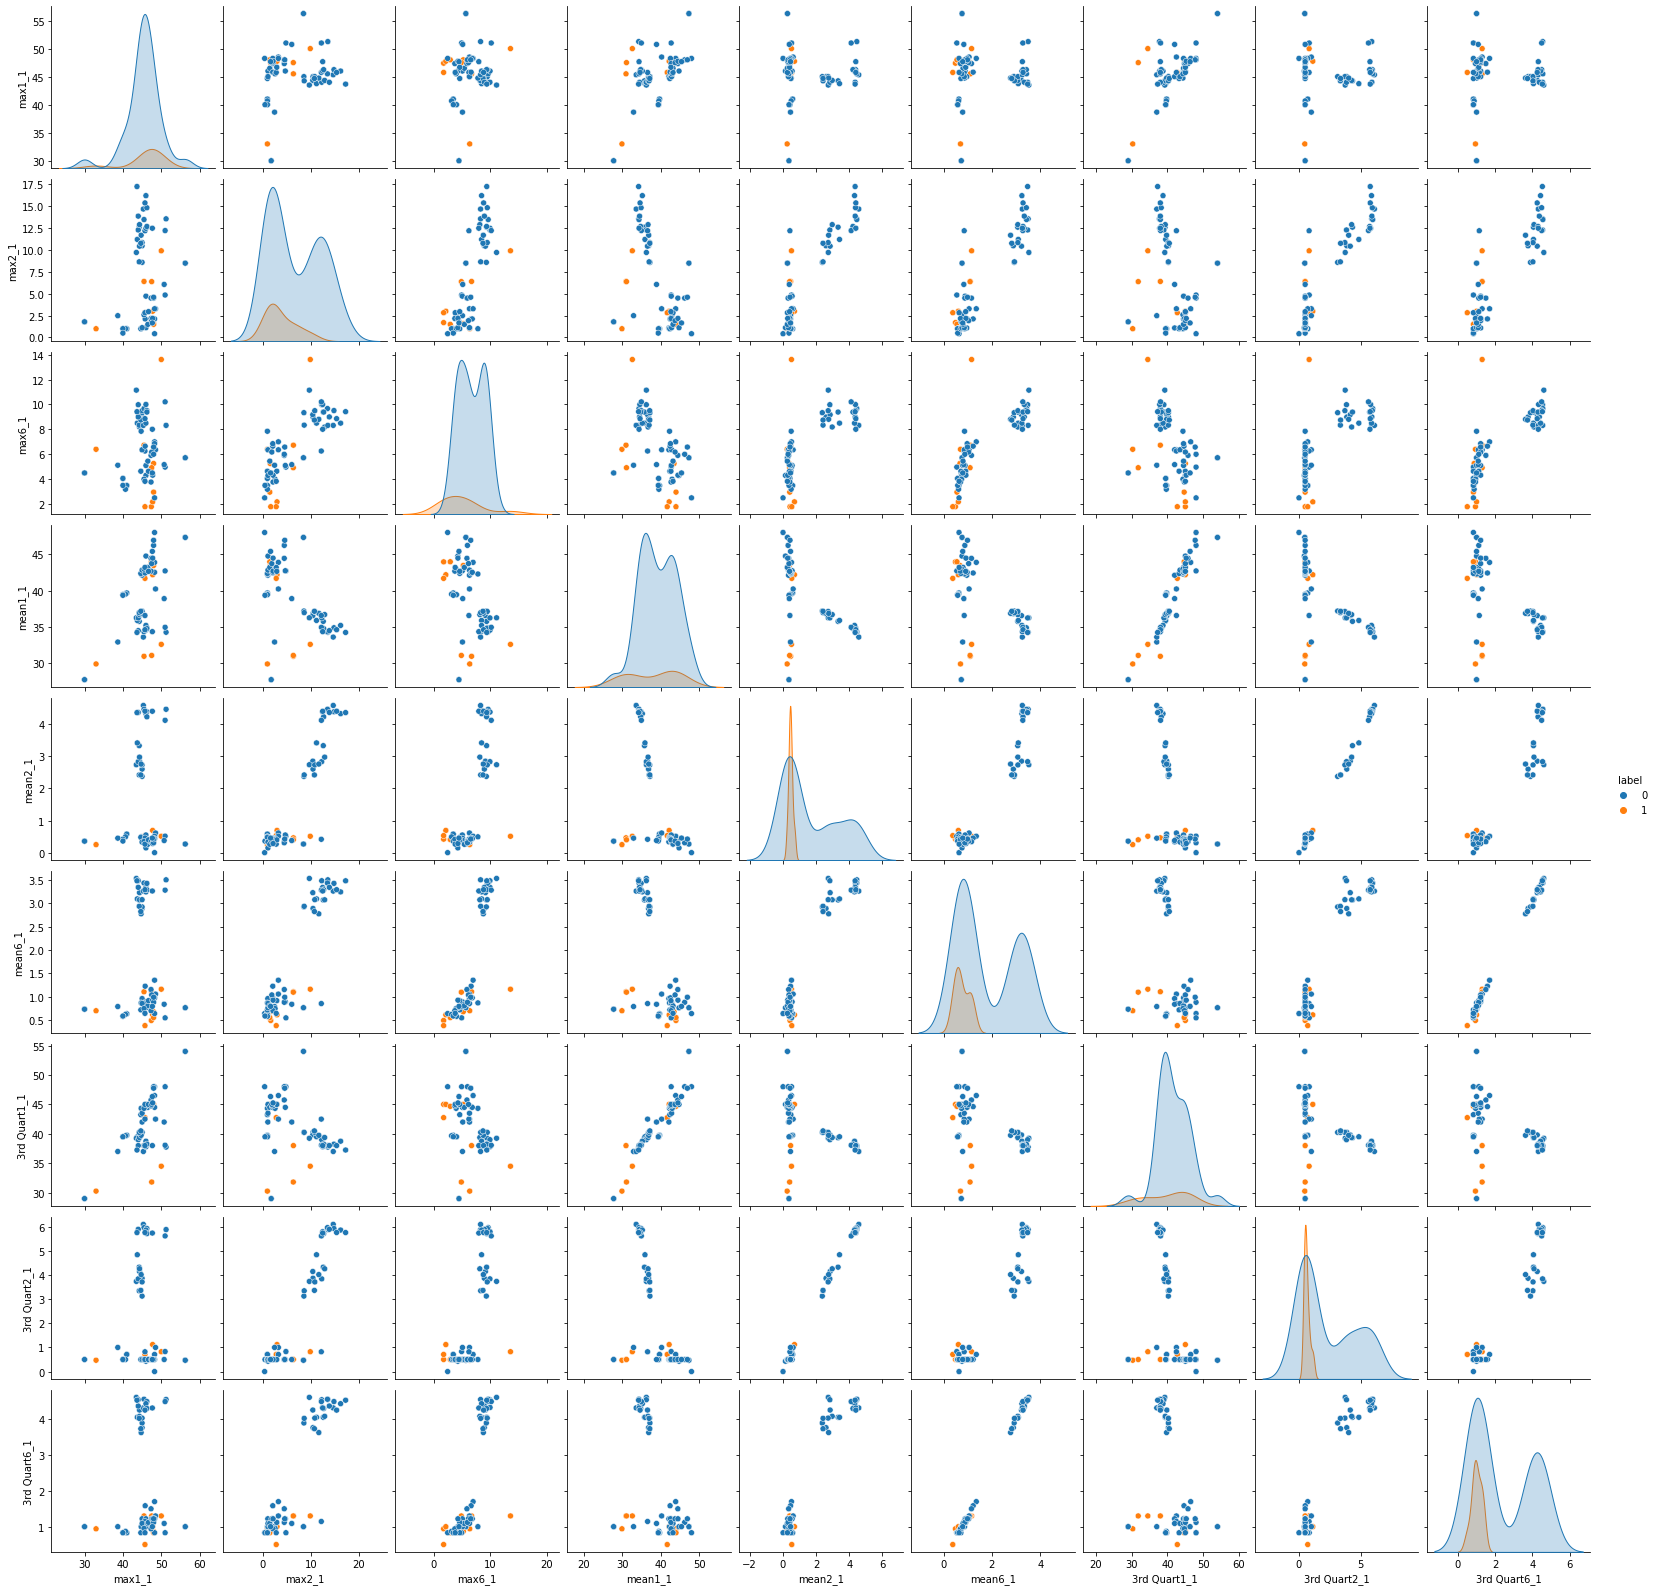

In [22]:
sns.pairplot(data=scatter_train_data, hue="label")

### ii) Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [23]:
scatter_train_data_2 = prepareData(train_folder,2,True)

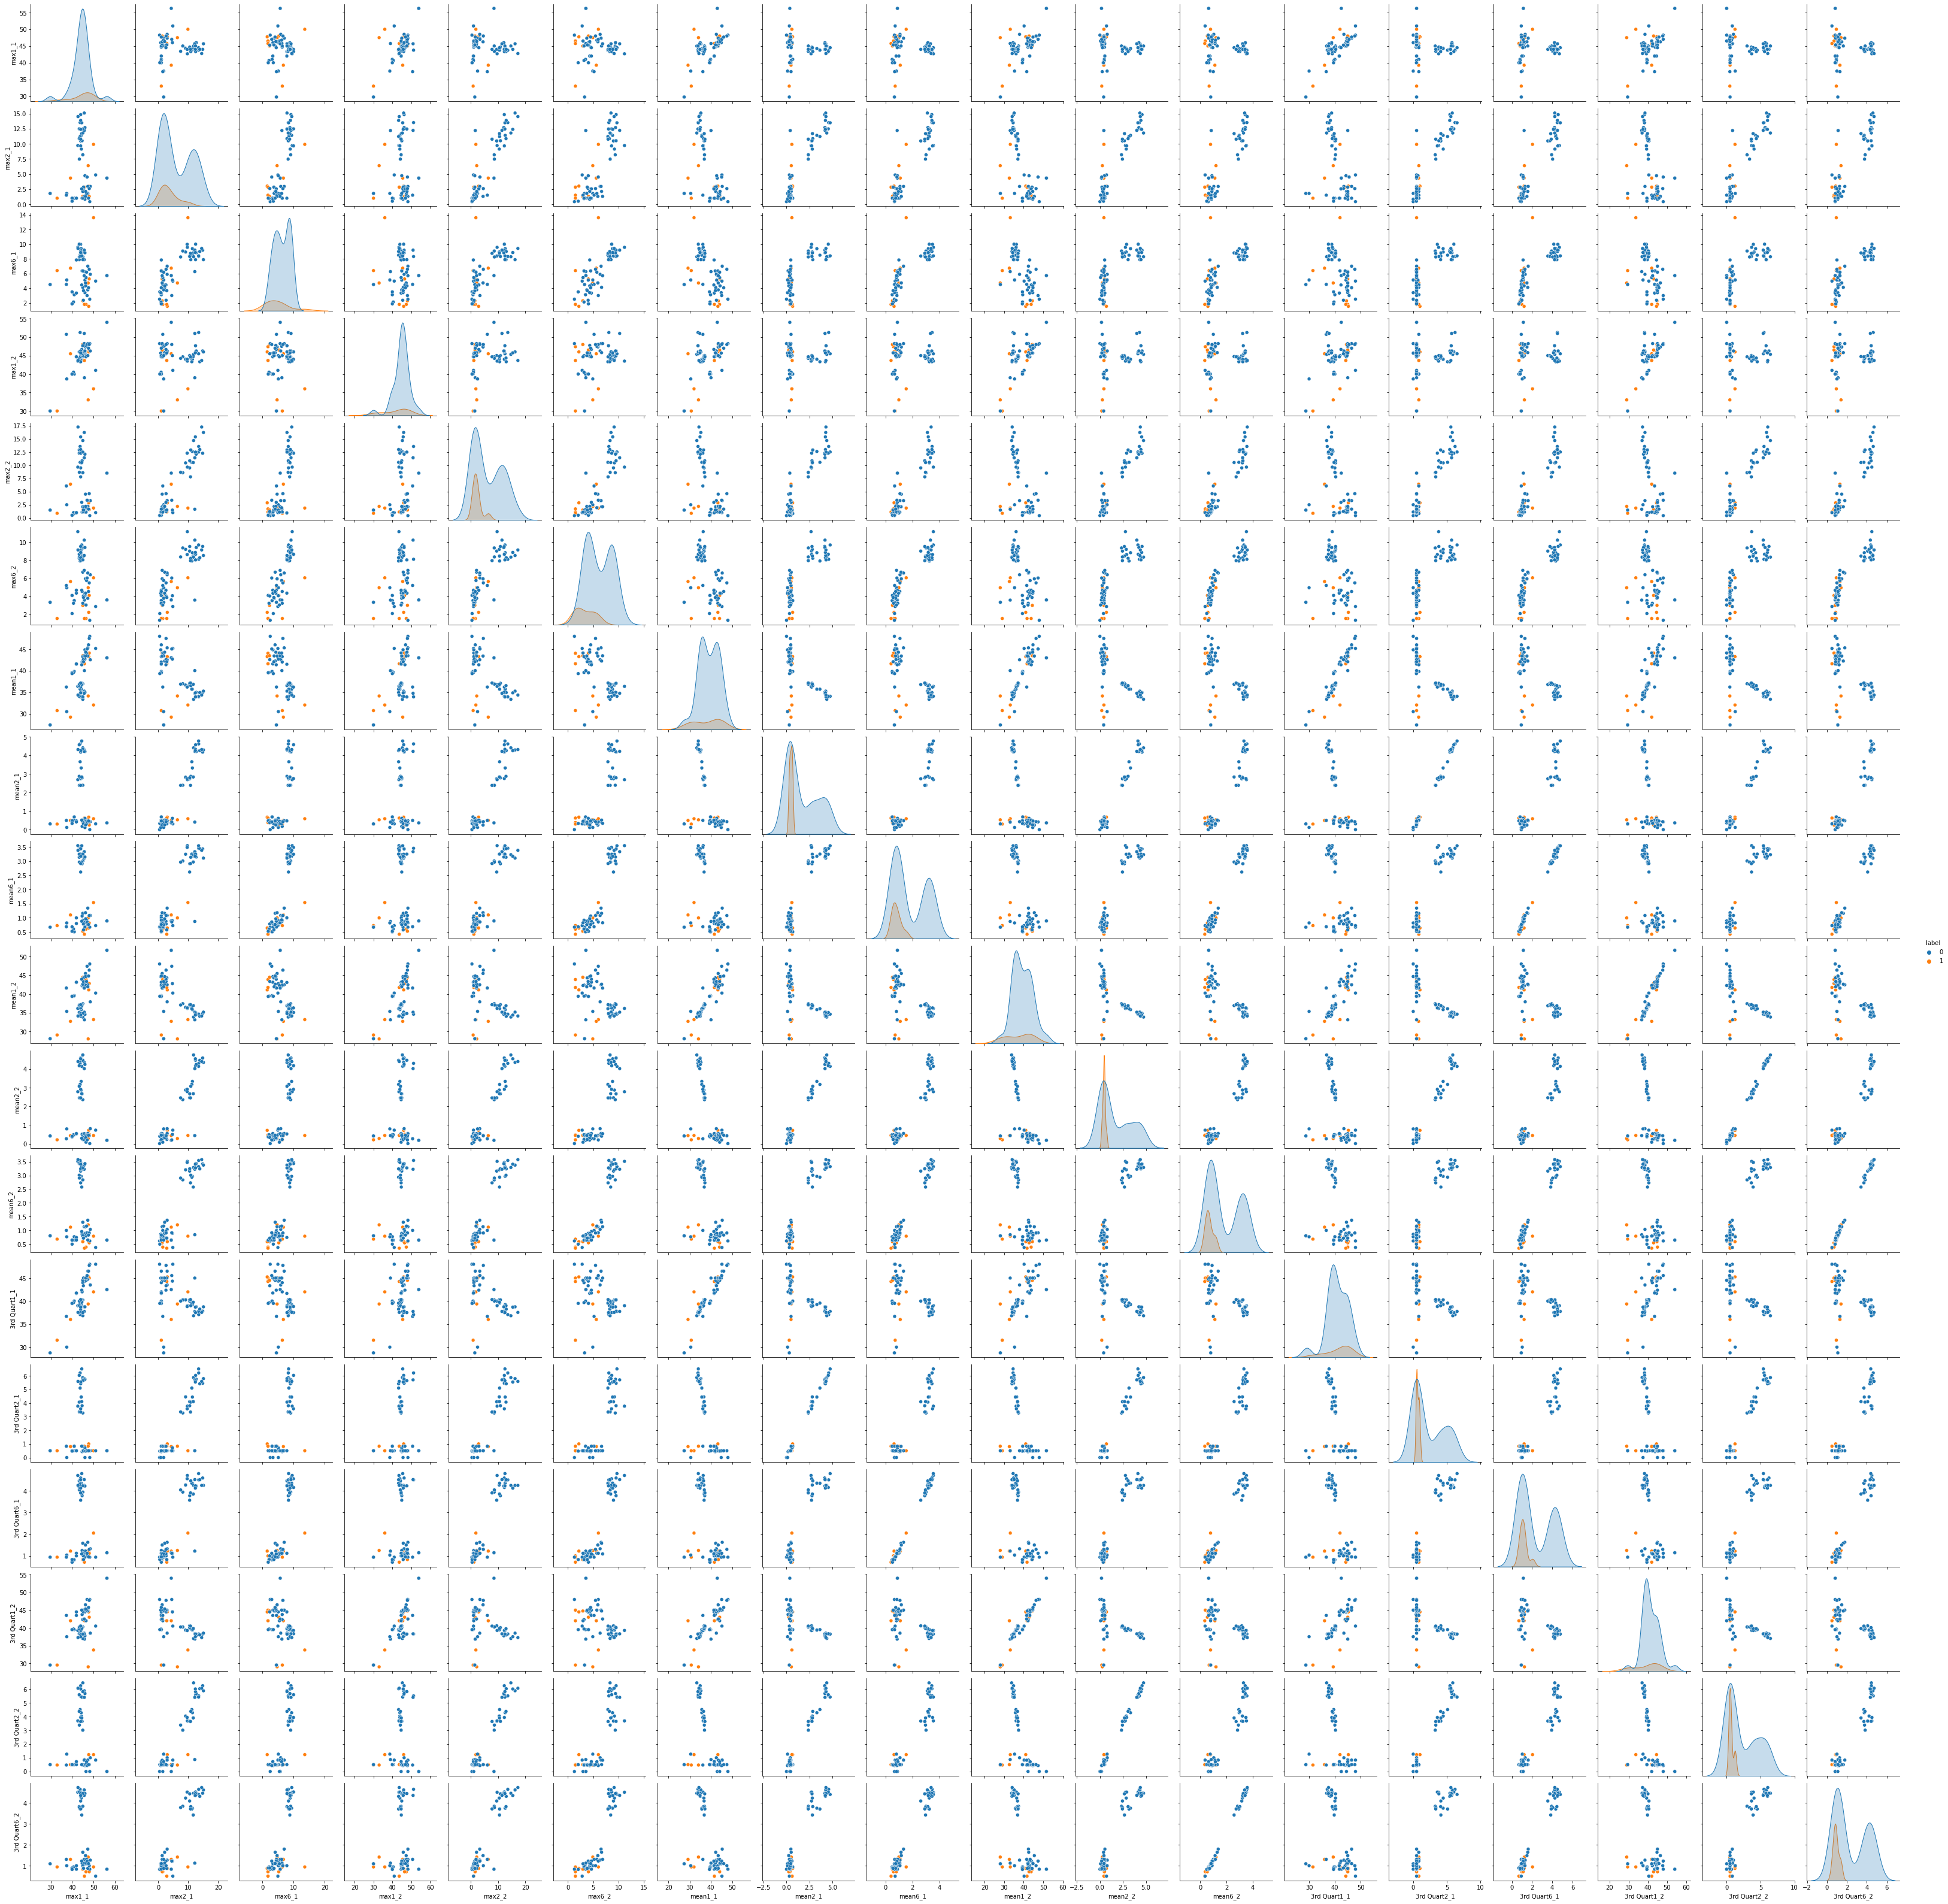

In [24]:
sns.pairplot(data=scatter_train_data_2, hue="label")

<b><i>Question .</i>Do you see any considerable difference in the results with those of 2(a)i?</b>

<i>Ans .</i>There is not any evident difference visible between the scatter plots of 2(a)i and 2(a)ii.

In [25]:
accuracy_table = PrettyTable(["Model","Training Accuracy","Testing Accuracy"])

### iii) Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.


The wrong way to perform Cross Validation would be:
- Extract features first on the basis of correlation
- Use the features to train model
- Use Cross-Validation to get select the best model

The Right way would be:
- Use Cross Validation first and divide dataset into k-folds
- Use k-1 folds as training set and try various features and test on kth fold
- Use the best set of features to decide the final model


In [26]:
table = PrettyTable(["Task","Best L Value","Best P value"])

In [27]:
# trainLogisticRegression -> function that implements Logistic Regression and find best features using RFECV
def trainLogisticRegression(trainData):
    cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    logit_model = LogisticRegression(max_iter=100)
    rfecv = RFECV(estimator=logit_model,step=1,cv=cv,min_features_to_select=1,n_jobs=-1)
    rfecv.fit(trainData.drop("label",axis=1).values, trainData["label"].values)
    return rfecv

In [28]:
l_range = np.arange(1,21)
p_numOfFeatures = []
score_list = []
test_score_list = []
best_l_val = -1
best_p_val = -1
best_score = -1
for l in l_range:
    print("Running for l = ",l)
    trainingData = prepareData(train_folder,l)
    back_selection = trainLogisticRegression(trainingData)
    p_numOfFeatures.append(back_selection.n_features_)
    score_list.append(back_selection.cv_results_["mean_test_score"][back_selection.n_features_-1])
    if score_list[-1]>best_score:
        best_score = score_list[-1]
        best_l_val = l
        best_p_val = p_numOfFeatures[-1]
table.add_row(["2-A-iii(Before Resampling)",str(best_l_val),str(best_p_val)])

Running for l =  1
Running for l =  2
Running for l =  3
Running for l =  4
Running for l =  5
Running for l =  6
Running for l =  7
Running for l =  8
Running for l =  9
Running for l =  10
Running for l =  11
Running for l =  12
Running for l =  13
Running for l =  14
Running for l =  15
Running for l =  16
Running for l =  17
Running for l =  18
Running for l =  19
Running for l =  20


In [29]:
df_rfecv = pd.DataFrame(data={"L value":l_range,"P value":p_numOfFeatures,"cv_score":score_list})

In [30]:
df_rfecv

,L value,P value,cv_score
0,1,4,0.971429
1,2,3,0.957143
2,3,1,0.971429
3,4,1,0.971429
4,5,9,0.985714
5,6,13,0.985714
6,7,24,0.985714
7,8,14,0.985714
8,9,11,0.971429
9,10,41,0.971429


In [31]:
best_l_val

5

### iv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi ’s as well as the p-values associated with them.

In [32]:
finalTrainingData = prepareData(train_folder,best_l_val)
rfecv_model = trainLogisticRegression(finalTrainingData)

X_train = finalTrainingData.drop("label",axis=1).iloc[:,rfecv_model.support_]
y_train = finalTrainingData["label"]

final_logit_model = LogisticRegression(max_iter=100)
final_logit_model.fit(X_train,y_train)
y_pred_train = final_logit_model.predict(X_train)


In [33]:
print("Accuracy for L = "+str(best_l_val)+" on train data is :"+str(accuracy_score(y_train,y_pred_train)*100))

Accuracy for L = 5 on train data is :100.0


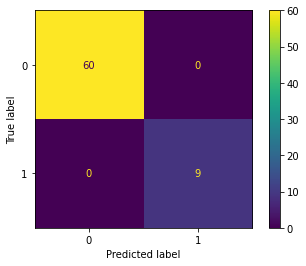

In [34]:
cm = confusion_matrix(y_train, y_pred_train, labels=final_logit_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_logit_model.classes_)
disp.plot()
plt.show()

roc_auc_score for Logistic Regression:  1.0


Text(0.5, 0, 'False Positive Rate')

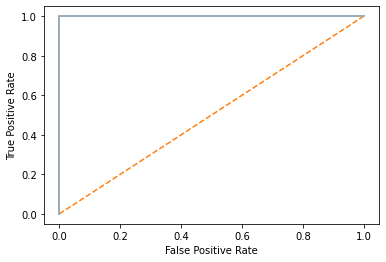

In [35]:
y_score = final_logit_model.predict_proba(X_train)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_score)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_train, y_score))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [36]:
scores, pvalues = chi2(X_train, y_train)
coeff = pd.DataFrame({'Features' : X_train.columns, 'Coefficient' : final_logit_model.coef_[0], 'pvalues':pvalues})
display(coeff)

,Features,Coefficient,pvalues
0,max5_1,0.333000,5.397202e-13
1,max2_2,-0.161983,4.282094e-03
2,max3_3,-0.165055,2.240166e-02
3,max6_5,-0.250544,3.808649e-04
4,mean5_1,0.315252,4.435183e-19
5,mean5_5,0.204020,1.494341e-09
6,3rd Quart5_1,0.390835,6.529629e-18
7,3rd Quart1_3,-0.389313,1.376493e-01
8,3rd Quart5_5,0.188488,9.928800e-08


### v) Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.


Accuracy for L = 5 on test data is :94.73684210526315


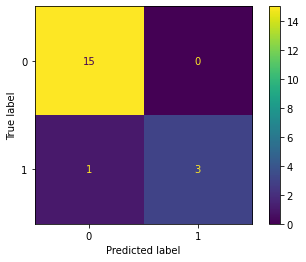

In [37]:
finalTestingData = prepareData(test_folder,best_l_val)
X_test = finalTestingData.drop("label",axis=1).iloc[:,rfecv_model.support_]
y_test = finalTestingData["label"]
# y_pred = np.around(final_log_reg.predict(X_test))
y_pred = final_logit_model.predict(X_test)
print("Accuracy for L = "+str(best_l_val)+" on test data is :"+str(accuracy_score(y_test,y_pred)*100))
cm = confusion_matrix(y_test, y_pred, labels=final_logit_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_logit_model.classes_)
disp.plot()
plt.show()

roc_auc_score for Logistic Regression on Test Data:  1.0


Text(0.5, 0, 'False Positive Rate')

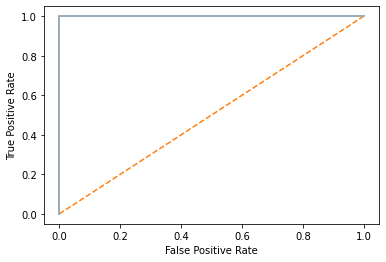

In [38]:
y_score_test = final_logit_model.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_test)
print('roc_auc_score for Logistic Regression on Test Data: ', roc_auc_score(y_test, y_score_test))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [39]:
accuracy_table.add_row(["Logistic Regression with Backward Feature Selection",str(accuracy_score(y_train,y_pred_train)*100),str(accuracy_score(y_test,y_pred)*100)])

#### Training Accuracy is 100% compared to Testing Accuracy of 94.73%

### vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

<p><i>Ans. </i>The classes seem to be well saperated to cause class instability. As we can see, when we try to build logistic regression model using statsmodels we are getting the error of PerfectSeparation which indicates class instability</p>

In [40]:
# Training a logistic Regression model using Statsmodels
log_reg = sm.Logit(y_train, X_train).fit()

PerfectSeparationError: Perfect separation detected, results not available

### vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

<p><i>Ans. </i>Class imbalance is clearly visible in the Confusion Matrices above. For training data we have 60 instances of class-0 and only 9 instances of class-1. We will use SMOTE technique to upsample the datapoints in the minority class and test and model on the testing data.
</p>


In [41]:
# sampleData -> takes the original data and sampling ratio as input and use SMOTE to resample datapoints
def sampleData(data, ratio):
    smote = SMOTE(sampling_strategy=ratio,random_state=0)
    X_resampled, y_resampled= smote.fit_resample(data.drop("label",axis=1),data["label"])
    return X_resampled, y_resampled

In [42]:
# trainLogisticRegressionSample -> It is similar function as above mentioned but built for resampled data
def trainLogisticRegressionResample(trainData, testData):
    cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    logit_model = LogisticRegression(max_iter=100)
    rfecv = RFECV(estimator=logit_model,step=1,cv=cv,min_features_to_select=1,n_jobs=-1)
    rfecv.fit(trainData.values, testData.values)
    return rfecv

In [43]:
l_range = np.arange(1,21)
p_resampled_numOfFeatures = []
resampled_score_list = []
best_l_val = -1
best_p_val = -1
best_score = -1

for l in l_range:
    print("Running for l = ",l)
    trainingData = prepareData(train_folder,l)
    resampled_train, resampled_test = sampleData(trainingData,0.5)
    resampled_back_selection = trainLogisticRegressionResample(resampled_train,resampled_test)
    p_resampled_numOfFeatures.append(resampled_back_selection.n_features_)
    resampled_score_list.append(resampled_back_selection.cv_results_["mean_test_score"][resampled_back_selection.n_features_-1])
    
    if resampled_score_list[-1]>best_score:
        best_score = resampled_score_list[-1]
        best_l_val = l
        best_p_val = p_resampled_numOfFeatures[-1]
table.add_row(["After Resampling",str(best_l_val),str(best_p_val)])

Running for l =  1
Running for l =  2
Running for l =  3
Running for l =  4
Running for l =  5
Running for l =  6
Running for l =  7
Running for l =  8
Running for l =  9
Running for l =  10
Running for l =  11
Running for l =  12
Running for l =  13
Running for l =  14
Running for l =  15
Running for l =  16
Running for l =  17
Running for l =  18
Running for l =  19
Running for l =  20


In [44]:
df_resampling = pd.DataFrame(data={"L value":l_range,"P value":p_resampled_numOfFeatures,"cv_score":resampled_score_list})

In [45]:
df_resampling

,L value,P value,cv_score
0,1,3,0.988889
1,2,3,1.000000
2,3,4,1.000000
3,4,13,0.988889
4,5,6,0.988889
5,6,21,1.000000
6,7,7,0.988889
7,8,11,0.988889
8,9,10,0.988889
9,10,11,0.988889


In [46]:
print("Best Value of L before and After Resampling : ")
print(table)

Best Value of L before and After Resampling : 
+----------------------------+--------------+--------------+
|            Task            | Best L Value | Best P value |
+----------------------------+--------------+--------------+
| 2-A-iii(Before Resampling) |      5       |      9       |
|      After Resampling      |      2       |      3       |
+----------------------------+--------------+--------------+


#### Comfusion Matrix and ROC curve for Training Data for 2a-vii

In [47]:

finalTrainingDataResampling = prepareData(train_folder, best_l_val)
X_train_resampled, y_train_resampled = sampleData(finalTrainingDataResampling, 0.5)
rfecv_resampling = trainLogisticRegressionResample(X_train_resampled, y_train_resampled)
X_train_resampled = X_train_resampled.iloc[:,rfecv_resampling.support_]

Accuracy for model(trained on resampled data) on Train Data is :  1.0


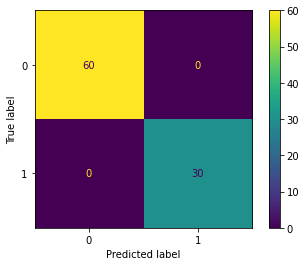

roc_auc_score for Logistic Regression:  1.0


Text(0.5, 0, 'False Positive Rate')

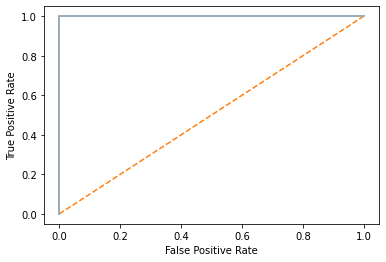

In [48]:
resampled_logit_model = LogisticRegression(max_iter=100)
resampled_logit_model.fit(X_train_resampled,y_train_resampled)


print("Accuracy for model(trained on resampled data) on Train Data is : ",accuracy_score(y_train_resampled, resampled_logit_model.predict(X_train_resampled)))
cm = confusion_matrix(y_train_resampled, resampled_logit_model.predict(X_train_resampled), labels=resampled_logit_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=resampled_logit_model.classes_)
disp.plot()
plt.show()

y_score_resample = resampled_logit_model.predict_proba(X_train_resampled)[:,1]
false_positive_rate_resample , true_positive_rate_resample, threshold_resample = roc_curve(y_train_resampled, y_score_resample)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_train_resampled, y_score_resample))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### Comfusion Matrix and ROC curve for Testing Data for 2a-vii

Accuracy for model(trained on resampled data) on Test Data is :  0.9473684210526315


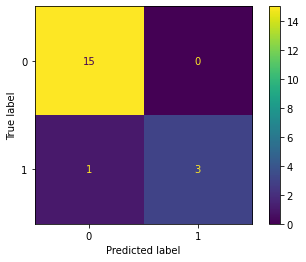

roc_auc_score for Case-Controlled Logistic Regression on Test Data:  0.8166666666666667


Text(0.5, 0, 'False Positive Rate')

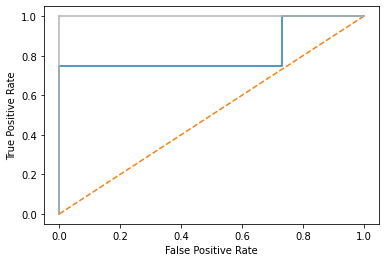

In [49]:
finalTestingDataResampling = prepareData(test_folder, best_l_val)
X_test_resampling, y_test_resampling = finalTestingDataResampling.drop("label",axis=1), finalTestingDataResampling["label"]
X_test_resampling = X_test_resampling.iloc[:,rfecv_resampling.support_]
y_pred_resampling = resampled_logit_model.predict(X_test_resampling)
print("Accuracy for model(trained on resampled data) on Test Data is : ",accuracy_score(y_test_resampling, y_pred_resampling))
cm = confusion_matrix(y_test_resampling, y_pred_resampling, labels=resampled_logit_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=resampled_logit_model.classes_)
disp.plot()
plt.show()

y_score_resampling = resampled_logit_model.predict_proba(X_test_resampling)[:,1]
false_positive_rate_resample, true_positive_rate_resample, threshold_resample = roc_curve(y_test_resampling, y_score_resampling)
print('roc_auc_score for Case-Controlled Logistic Regression on Test Data: ', roc_auc_score(y_test_resampling, y_score_resampling))
plt.plot(false_positive_rate_resample, true_positive_rate_resample)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [50]:
accuracy_table.add_row(["Logistic Regression with Resampling and Backward Feature Selection",str(accuracy_score(y_train_resampled, resampled_logit_model.predict(X_train_resampled))*100),str(accuracy_score(y_test_resampling, y_pred_resampling)*100)])

# Part 2 - b : Binary Classification Using L1-penalized logistic regression


### i. Repeat 2(a)iii using L1-penalized logistic regression i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [51]:
table1 = PrettyTable(["Task","Best Value for L","Value for C associated with L"])

In [52]:
# trainLogisticRegressionL1 -> Takes data as input and uses LogisticRegressionCV to find best values of lambda with penalty L1.
def trainLogisticRegressionL1(data,classification):
    cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(data.drop("label",axis=1))
    logit_model = LogisticRegressionCV(solver=classification,penalty='l1',cv=cv,random_state=0,n_jobs=-1)
    logit_model.fit(X_train_scaled, data["label"].values)
    score = logit_model.score(X_train_scaled, data["label"])
    best_C = logit_model.C_[0]
    best_C_ind = -1
    for i in range(len(logit_model.Cs_)):
        if i==best_C:
            best_C_ind=i
    
    return logit_model,np.mean(logit_model.scores_[1][:,best_C_ind])

#### Finding best value of L and corresponding lambda for L = 1 to 20

In [53]:
l_range_l1 = np.arange(1,21)
p_list_l1 = []
score_list = []
C_value = []
best_l_val = -1
best_C_val = -1
best_col = None
best_score_val = -1

for l in l_range:
    print("Running for l = ",l)
    trainingData = prepareData(train_folder,l)
    l1_selection, score = trainLogisticRegressionL1(trainingData,"liblinear")
    p_list_l1.append(sum([1 if ii != 0 else 0 for ii in l1_selection.coef_[0]])-1)
    print(score)
    score_list.append(score)
    C_value.append(l1_selection.C_[0])
    
    if score_list[-1]>best_score_val:
        best_score_val = score_list[-1]
        best_l_val = l
        best_C_val = C_value[-1]
        col = []
        for c in l1_selection.coef_[0]:
            if c==0:
                col.append(False)
            else:
                col.append(True)
        best_col = col
table1.add_row(["Logistic Regression with L1 Penalty",str(best_l_val),str(best_C_val)])

Running for l =  1
0.9417582417582417
Running for l =  2
0.9131868131868132
Running for l =  3
0.9428571428571428
Running for l =  4
0.9571428571428571
Running for l =  5
0.9571428571428571
Running for l =  6
0.9571428571428571
Running for l =  7
0.9428571428571428
Running for l =  8
0.9571428571428571
Running for l =  9
0.9417582417582417
Running for l =  10
0.9571428571428571
Running for l =  11
0.9571428571428571
Running for l =  12
0.9571428571428571
Running for l =  13
0.9428571428571428
Running for l =  14
0.9274725274725275
Running for l =  15
0.9428571428571428
Running for l =  16
0.9428571428571428
Running for l =  17
0.9571428571428571
Running for l =  18
0.9428571428571428
Running for l =  19
0.9131868131868132
Running for l =  20
0.9571428571428571


In [54]:
df_l1 = pd.DataFrame(data={"L value":l_range,"P value":p_list_l1,"cv_score":score_list,"C":C_value})

In [55]:
df_l1

,L value,P value,cv_score,C
0,1,5,0.941758,2.782559
1,2,6,0.913187,21.544347
2,3,3,0.942857,0.359381
3,4,30,0.957143,1291.549665
4,5,13,0.957143,166.810054
5,6,16,0.957143,166.810054
6,7,19,0.942857,166.810054
7,8,23,0.957143,166.810054
8,9,44,0.941758,1291.549665
9,10,53,0.957143,1291.549665


#### Training the final model on Train Data and evaluating it on Test Data

In [56]:
final_L1_Training_Data = prepareData(train_folder,best_l_val)
final_L1_Testing_Data = prepareData(test_folder, best_l_val)

final_logit_model_l1 = LogisticRegression(C=best_C_val, solver="liblinear",penalty="l1",random_state=0,n_jobs=-1)
final_logit_model_l1.fit(final_L1_Training_Data.drop("label",axis=1).values,final_L1_Training_Data["label"])

LogisticRegression(C=1291.5496650148827, n_jobs=-1, penalty='l1',
                   random_state=0, solver='liblinear')

In [57]:
final_l1_accuracy = accuracy_score(final_L1_Testing_Data["label"],final_logit_model_l1.predict(final_L1_Testing_Data.drop("label",axis=1).values))
print("Accuracy for Logistic Regression with L1 Penalty is : ",  final_l1_accuracy)

Accuracy for Logistic Regression with L1 Penalty is :  1.0


#### Confusion Matrix and ROC for training data for Logistic Regression with L1 penalty

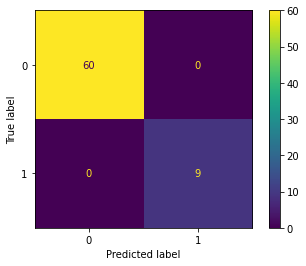

roc_auc_score for Logistic Regression(Training):  1.0


Text(0.5, 0, 'False Positive Rate')

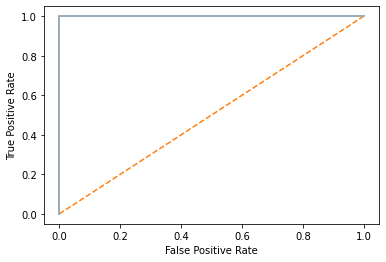

In [58]:
cm = confusion_matrix(final_L1_Training_Data["label"], final_logit_model_l1.predict(final_L1_Training_Data.drop("label",axis=1)), labels=final_logit_model_l1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_logit_model_l1.classes_)
disp.plot()
plt.show()

y_score = final_logit_model_l1.predict_proba(final_L1_Training_Data.drop("label",axis=1).values)[:,1]
false_positive_rate , true_positive_rate, threshold = roc_curve(final_L1_Training_Data["label"].values, y_score)
print('roc_auc_score for Logistic Regression(Training): ', roc_auc_score(final_L1_Training_Data["label"].values, y_score))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### Confusion Matrix and ROC for Logistic Regression with L1 Penalty on Testing Data

Accuracy for Logistic Regression with L1 Penalty on Test Data is :  1.0


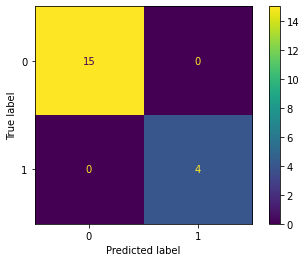

roc_auc_score for Logistic Regression(Testing):  1.0


Text(0.5, 0, 'False Positive Rate')

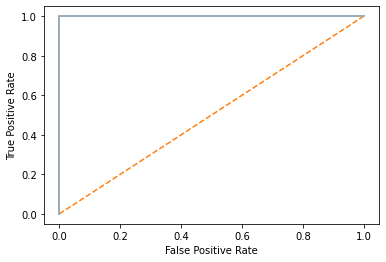

In [59]:
y_pred_l1 = final_logit_model_l1.predict(final_L1_Testing_Data.drop("label",axis=1))
final_l1_accuracy_test = accuracy_score(final_L1_Testing_Data["label"],y_pred_l1)
print("Accuracy for Logistic Regression with L1 Penalty on Test Data is : ",  final_l1_accuracy_test)
cm = confusion_matrix(final_L1_Testing_Data["label"], y_pred_l1, labels=final_logit_model_l1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_logit_model_l1.classes_)
disp.plot()
plt.show()

y_score = final_logit_model_l1.predict_proba(final_L1_Testing_Data.drop("label",axis=1).values)[:,1]
false_positive_rate , true_positive_rate, threshold = roc_curve(final_L1_Testing_Data["label"].values, y_score)
print('roc_auc_score for Logistic Regression(Testing): ', roc_auc_score(final_L1_Testing_Data["label"].values, y_score))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [60]:
accuracy_table.add_row(["Logistic Regression with L1 Penalty and Feature Selection",str(final_l1_accuracy*100),str(final_l1_accuracy_test*100)])

### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

<p><i>Ans. </i> Compared to backward selection with 94.73 % accuracy, L1-Penalized with variable seletction works better on Test Data with 100% accuracy. Also Logistic Regression with L1-Penalty is more easier to implement compared to the other one.</p>



# Part - 2 - c : Multi-class Classification (The Realistic Case)

### i. Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [61]:
# prepareDataMulticlass -> Function that prepares data for different values of L for Multiclass Classification

label_dict = {"bending1":0, "bending2":1,"cycling":2,"lying":3, "sitting":4, "standing":5, "walking":6}
    
def prepareDataMulticlass(folder,k,scatter=False):
    cols = col_names(k,scatter)
    cols.append("label")
    final_dataset_list = []
    for file in folder:
        temp_df = pd.read_csv(file,skiprows=4)
        label_v = file.split("/")[3]
        splits = np.array_split(temp_df,k)
        data_list = []
        for i in range(len(splits)):
            if scatter:
                data_list.extend(splits[i].iloc[:,[1,2,6]].max())
                continue
            data_list.extend(splits[i].iloc[:,1:].max())      

        for i in range(len(splits)):
            if scatter:
                data_list.extend(splits[i].iloc[:,[1,2,6]].mean())
                continue
            data_list.extend(splits[i].iloc[:,1:].mean())

        for i in range(len(splits)):
            if scatter:
                data_list.extend(splits[i].iloc[:,[1,2,6]].quantile(0.75))
                continue
            data_list.extend(splits[i].iloc[:,1:].quantile(0.75))
        data_list.append(label_v)
        
        final_dataset_list.append(data_list)

    final_dataset = pd.DataFrame(data=final_dataset_list, columns=cols)
    le = LabelEncoder()
    le.fit(final_dataset["label"])
    final_dataset["Encoded_Label"] = le.transform(final_dataset["label"])
    return final_dataset
        

In [62]:
# trainLogisticRegressionL1Multiclass -> Function that implements LogisticRegressionCV to find best values of lambda for Logistic 
# Regression with "saga" as solver and "l1" penalty

def trainLogisticRegressionL1Multiclass(data,classification):
    cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(data.drop(["label","Encoded_Label"],axis=1))
    logit_model = LogisticRegressionCV(solver=classification, penalty='l1',cv=cv,random_state=0,n_jobs=-1)
    logit_model.fit(X_train_scaled, data["Encoded_Label"].values)
    score = logit_model.score(X_train_scaled, data["Encoded_Label"])
    best_C = logit_model.C_[0]
    best_C_ind = -1
    for i in range(len(logit_model.Cs_)):
        if i==best_C:
            best_C_ind=i
            
    global_mean = 0
    for k in logit_model.scores_:
        global_mean += np.mean(logit_model.scores_[k][:,best_C_ind])
    
    return logit_model,global_mean/7

#### Looping through L=1 to 20 to find best values of L and lambda for Multiclass

In [63]:
l_range_l1 = np.arange(1,21)
p_list_l1_multiclass = []
score_list_multiclass = []
C_value_multiclass = []
col_to_select = []
best_l_val =-1
best_C_val =-1
best_score = -1

for l in l_range_l1:
    print("Running for l = ",l)
    trainingData = prepareDataMulticlass(train_folder,l)
    l1_selection_multiclass, score_multiclass = trainLogisticRegressionL1Multiclass(trainingData,"saga")
    p_list_l1_multiclass.append(sum([1 if ii != 0 else 0 for ii in l1_selection_multiclass.coef_[0]])-1)
    col = []
    for c in l1_selection_multiclass.coef_[0]:
        if c!=0:
            col.append(False)
        else:
            col.append(True)
    print(score_multiclass)
    score_list_multiclass.append(score_multiclass)
    C_value_multiclass.append(l1_selection_multiclass.C_[0])
    col_to_select.append(col)
    if score_list_multiclass[-1]>best_score:
        best_score = score_list_multiclass[-1]
        best_C_val = C_value_multiclass[-1]
        best_l_val = l
table1.add_row(["Multiclass Logistic Regression with L1 Penalty",str(best_l_val),str(best_C_val)])

Running for l =  1
0.9285714285714286
Running for l =  2
0.8846153846153848
Running for l =  3
0.8703296703296701
Running for l =  4
0.8263736263736262
Running for l =  5
0.8846153846153848
Running for l =  6
0.8131868131868131
Running for l =  7
0.8560439560439559
Running for l =  8
0.8274725274725274
Running for l =  9
0.812087912087912
Running for l =  10
0.8263736263736262
Running for l =  11
0.8109890109890109
Running for l =  12
0.767032967032967
Running for l =  13
0.7824175824175824
Running for l =  14
0.7967032967032966
Running for l =  15
0.767032967032967
Running for l =  16
0.7538461538461538
Running for l =  17
0.812087912087912
Running for l =  18
0.7813186813186812
Running for l =  19
0.7978021978021977
Running for l =  20
0.7681318681318681


In [64]:
df_l1_multiclass = pd.DataFrame(data={"L value":l_range,"P value":p_list_l1_multiclass,"cv_score":score_list_multiclass,"C":C_value_multiclass,"cols_to_select":col_to_select})

In [65]:
df_l1_multiclass

,L value,P value,cv_score,C,cols_to_select
0,1,8,0.928571,21.544347,"[False, False, False, False, False, False, Fal..."
1,2,30,0.884615,166.810054,"[False, False, False, False, False, False, Fal..."
2,3,27,0.870330,21.544347,"[False, False, False, False, False, False, Fal..."
3,4,34,0.826374,21.544347,"[False, True, False, False, False, False, Fals..."
4,5,78,0.884615,166.810054,"[False, True, False, False, False, False, Fals..."
5,6,105,0.813187,1291.549665,"[False, False, False, False, False, False, Fal..."
6,7,59,0.856044,21.544347,"[False, True, False, False, False, False, True..."
7,8,74,0.827473,21.544347,"[False, True, False, True, False, False, False..."
8,9,92,0.812088,21.544347,"[False, True, False, False, False, False, Fals..."
9,10,179,0.826374,1291.549665,"[False, False, False, False, False, False, Fal..."


In [66]:
best_l_val

1

#### Training the final model with best values of L and lamda

In [67]:
logit_model_multiclass = LogisticRegression(penalty="l1",C=best_C_val,solver="saga")
trainingDataMulticlass = prepareDataMulticlass(train_folder,best_l_val)
col = df_l1_multiclass["cols_to_select"][best_l_val-1]
X_train_multiclass = trainingDataMulticlass.drop(["label","Encoded_Label"],axis=1).iloc[:,col]
y_train_multiclass = trainingDataMulticlass["Encoded_Label"]
testingDataMulticlass = prepareDataMulticlass(test_folder,best_l_val)
X_test_multiclass = testingDataMulticlass.drop(["label","Encoded_Label"],axis=1).iloc[:,col]
y_test_multiclass = testingDataMulticlass["Encoded_Label"]
sc = StandardScaler()
sc.fit(X_train_multiclass)
X_train_multiclass = sc.transform(X_train_multiclass)
X_test_multiclass = sc.transform(X_test_multiclass)
logit_model_multiclass.fit(X_train_multiclass,y_train_multiclass)

LogisticRegression(C=21.54434690031882, penalty='l1', solver='saga')

In [68]:
multiclass_accuracy_training = accuracy_score(y_train_multiclass, logit_model_multiclass.predict(X_train_multiclass))
print("Accuracy for Logistic Regression for Mutliclass : ",multiclass_accuracy_training)

Accuracy for Logistic Regression for Mutliclass :  0.9420289855072463


#### Confusion Matrix for Training Data

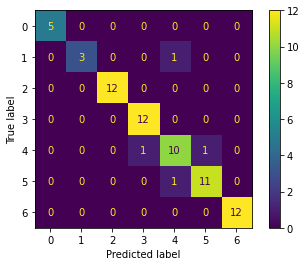

{'bending1': 0, 'bending2': 1, 'cycling': 2, 'lying': 3, 'sitting': 4, 'standing': 5, 'walking': 6}


In [69]:
cm = confusion_matrix(y_train_multiclass, logit_model_multiclass.predict(X_train_multiclass), labels=logit_model_multiclass.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit_model_multiclass.classes_)
disp.plot()
plt.show()
print(label_dict)

In [88]:
y_pred_multiclass = logit_model_multiclass.predict(X_test_multiclass)
multiclass_accuracy_testing = accuracy_score(y_test_multiclass,y_pred_multiclass)
print("Accuracy for Best model for Multiclass Classification is :",multiclass_accuracy_testing*100)
print("Test Error for Best Model for Multiclass Classification is :",1-multiclass_accuracy_testing)

Accuracy for Best model for Multiclass Classification is : 89.47368421052632
Test Error for Best Model for Multiclass Classification is : 0.10526315789473684


#### Confusion Matrix for Test Data 

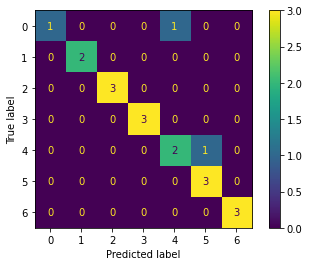

{'bending1': 0, 'bending2': 1, 'cycling': 2, 'lying': 3, 'sitting': 4, 'standing': 5, 'walking': 6}


In [71]:
cm = confusion_matrix(y_test_multiclass, y_pred_multiclass, labels=logit_model_multiclass.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit_model_multiclass.classes_)
disp.plot()
plt.show()
print(label_dict)

#### ROC curves for Multiclass Classification Training Data 

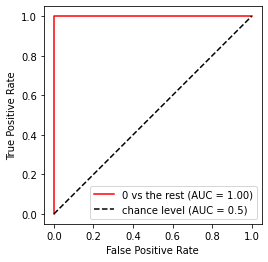

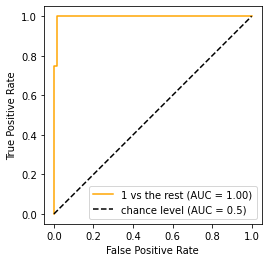

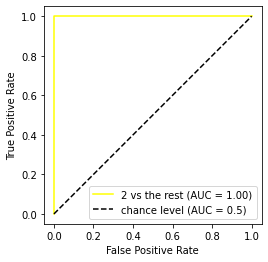

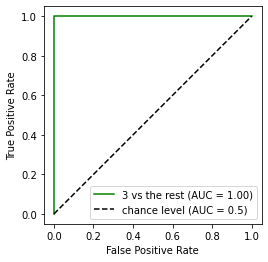

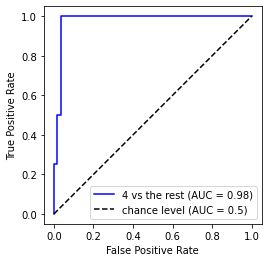

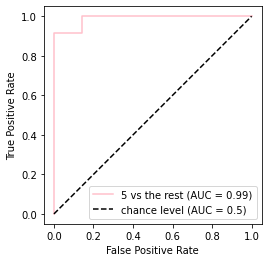

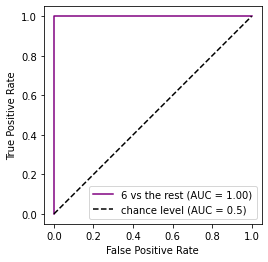

Area Under the Curve for Train set:  0.994646873594242


In [72]:
OHTrainY = LabelBinarizer().fit_transform(trainingDataMulticlass["label"])
classes = np.unique(y_train_multiclass) 
trainProb = logit_model_multiclass.predict_proba(X_train_multiclass)
color = ["red", "orange", "yellow", "green", "blue", "pink", "purple"]
for classOfInterest in classes:
    RocCurveDisplay.from_predictions(
        OHTrainY[:, classOfInterest],
        trainProb[:, classOfInterest],
        name=f"{classOfInterest} vs the rest",
        color=color[classOfInterest]
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
plt.show()


macro_roc_auc_ovr = roc_auc_score(
    y_train_multiclass,
    trainProb,
    multi_class="ovr",
    average="macro",
)
print("Area Under the Curve for Train set: ", macro_roc_auc_ovr)

#### ROC curves for Multiclass Classification Testing Data 

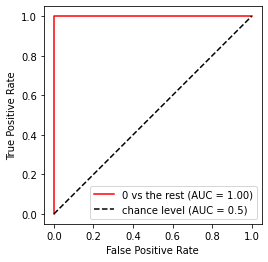

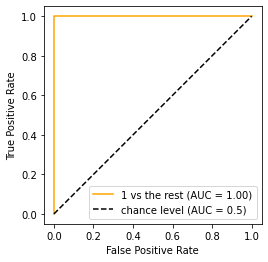

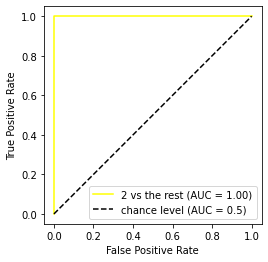

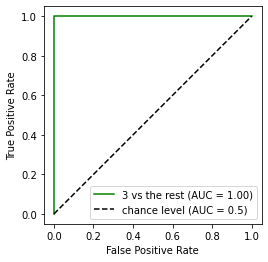

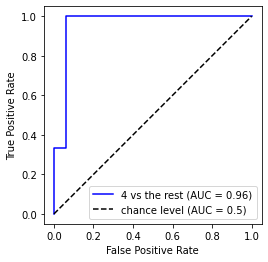

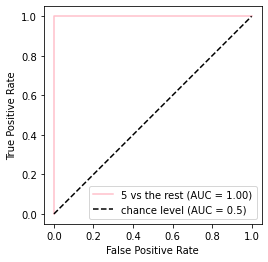

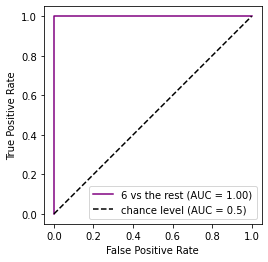

Area Under the Curve for Test set:  0.994047619047619


In [73]:
OHTestY = LabelBinarizer().fit_transform(testingDataMulticlass["label"])
classes = np.unique(y_test_multiclass) 
testProb = logit_model_multiclass.predict_proba(X_test_multiclass)
color = ["red", "orange", "yellow", "green", "blue", "pink", "purple"]
for classOfInterest in classes:
    RocCurveDisplay.from_predictions(
        OHTestY[:, classOfInterest],
        testProb[:, classOfInterest],
        name=f"{classOfInterest} vs the rest",
        color=color[classOfInterest]
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
plt.show()


macro_roc_auc_ovr = roc_auc_score(
    y_test_multiclass,
    testProb,
    multi_class="ovr",
    average="macro",
)
print("Area Under the Curve for Test set: ", macro_roc_auc_ovr)

In [74]:
accuracy_table.add_row(["Logistic Regression for Multiclass",str(multiclass_accuracy_training*100),str(multiclass_accuracy_testing*100)])

### ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [75]:
table2 = PrettyTable(["Task","Value for l"])

In [76]:
# trainNaiveBayes -> Function that takes instance of Naive Bayes model and implements it on training data to find best values of
# L.
def trainNaiveBayes(classifier):
    best_l_val = -1
    best_score = -1
    for l in range(1,21):
        print("Running for l = ",l)
        trainingData = prepareDataMulticlass(train_folder,l)
        nb = classifier
        score = cross_val_score(
            estimator=nb,
            X=trainingData.drop(["label","Encoded_Label"],axis=1).values, 
            y=trainingData["Encoded_Label"].values, 
            cv=StratifiedKFold(n_splits=5,random_state=0,shuffle=True), 
            scoring="accuracy"
        )
        print(np.mean(score))
        if np.mean(score)>best_score:
            best_score = np.mean(score)
            best_l_val = l
    return best_l_val, best_score


In [77]:
# testNaiveBayes -> Function that takes instance of Naive Bayes model, trains the final model and tests it on the test data. It
# also implements confusion matrix and ROC curve for Testing Data

nb_train_accuracy = None
nb_test_accuracy = None
mn_train_accuracy = None
mn_test_accuracy = None

def testNaiveBayes(classifer,l_val):
    global nb_train_accuracy
    global nb_test_accuracy
    global mn_train_accuracy
    global mn_test_accuracy
    
    NB_trainData = prepareDataMulticlass(train_folder, l_val)
    NB_testData = prepareDataMulticlass(test_folder,l_val)
    nb = classifer
    nb.fit(NB_trainData.drop(["label","Encoded_Label"],axis=1).values, NB_trainData["Encoded_Label"].values)
    y_pred_nb = nb.predict(NB_testData.drop(["label","Encoded_Label"],axis=1).values)
    
    if l_val==best_l_val_gb:
        nb_train_accuracy = accuracy_score(NB_trainData["Encoded_Label"].values, nb.predict(NB_trainData.drop(["label","Encoded_Label"],axis=1).values))
        nb_test_accuracy = accuracy_score(NB_testData["Encoded_Label"],y_pred_nb)
    else:
        mn_train_accuracy = accuracy_score(NB_trainData["Encoded_Label"].values, nb.predict(NB_trainData.drop(["label","Encoded_Label"],axis=1).values))
        mn_test_accuracy = accuracy_score(NB_testData["Encoded_Label"],y_pred_nb)
    
    cm = confusion_matrix(NB_testData["Encoded_Label"].values, y_pred_nb, labels=nb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
    disp.plot()
    plt.show()
    print(label_dict)
    
    OHTrainY = LabelBinarizer().fit_transform(NB_trainData["label"])
    classes = np.unique(NB_trainData["Encoded_Label"]) 
    trainProb = nb.predict_proba(NB_trainData.drop(["label","Encoded_Label"],axis=1).values)
    color = ["red", "orange", "yellow", "green", "blue", "pink", "purple"]
    for classOfInterest in classes:
        RocCurveDisplay.from_predictions(
            OHTrainY[:, classOfInterest],
            trainProb[:, classOfInterest],
            name=f"{classOfInterest} vs the rest",
            color=color[classOfInterest]
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
    plt.show()


    macro_roc_auc_ovr = roc_auc_score(
        NB_trainData["Encoded_Label"].values,
        trainProb,
        multi_class="ovr",
        average="macro",
    )
    print("Area Under the Curve for Train set: ", macro_roc_auc_ovr)
    
    return accuracy_score(NB_testData["Encoded_Label"].values,y_pred_nb)



In [78]:
best_l_val_gb, gb_score = trainNaiveBayes(GaussianNB())
table2.add_row(["Gaussian NB",str(best_l_val_gb)])

Running for l =  1
0.8395604395604396
Running for l =  2
0.8098901098901099
Running for l =  3
0.8098901098901099
Running for l =  4
0.8241758241758241
Running for l =  5
0.8395604395604396
Running for l =  6
0.856043956043956
Running for l =  7
0.8703296703296702
Running for l =  8
0.8395604395604396
Running for l =  9
0.810989010989011
Running for l =  10
0.8263736263736263
Running for l =  11
0.8406593406593406
Running for l =  12
0.8395604395604396
Running for l =  13
0.810989010989011
Running for l =  14
0.8395604395604396
Running for l =  15
0.810989010989011
Running for l =  16
0.8406593406593406
Running for l =  17
0.8252747252747252
Running for l =  18
0.810989010989011
Running for l =  19
0.8252747252747253
Running for l =  20
0.7967032967032968


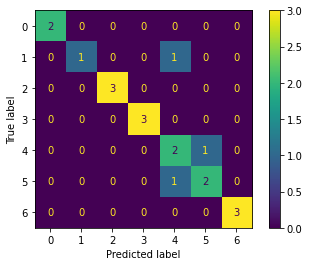

{'bending1': 0, 'bending2': 1, 'cycling': 2, 'lying': 3, 'sitting': 4, 'standing': 5, 'walking': 6}


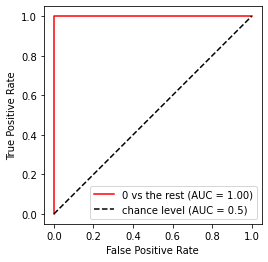

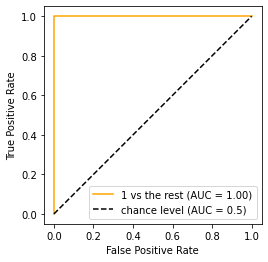

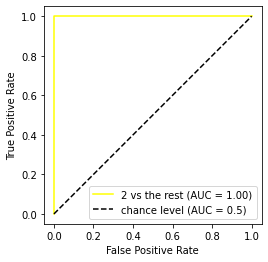

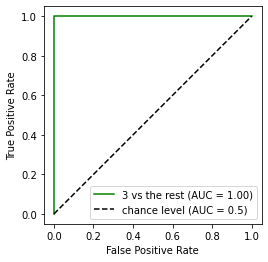

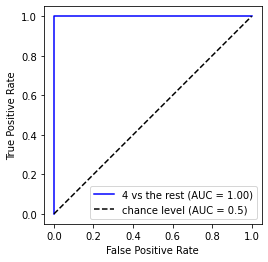

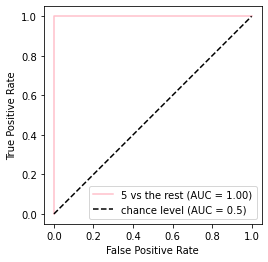

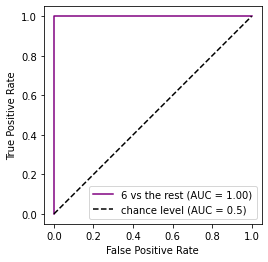

Area Under the Curve for Train set:  1.0
Accuracy Score for Gaussian Naive Bayes :  0.8421052631578947


In [79]:
print("Accuracy Score for Gaussian Naive Bayes : ",testNaiveBayes(GaussianNB(),best_l_val_gb))

In [90]:
print("Test Error for Gaussian Naive Bayes will be : ",1-nb_test_accuracy)

Test Error for Gaussian Naive Bayes will be :  0.1578947368421053


In [80]:
best_l_val_mn, mn_score = trainNaiveBayes(MultinomialNB())
table2.add_row(["Multinomial NB",str(best_l_val_mn)])

Running for l =  1
0.8417582417582418
Running for l =  2
0.856043956043956
Running for l =  3
0.8274725274725275
Running for l =  4
0.8406593406593406
Running for l =  5
0.8692307692307691
Running for l =  6
0.8263736263736263
Running for l =  7
0.8549450549450549
Running for l =  8
0.8120879120879121
Running for l =  9
0.8263736263736263
Running for l =  10
0.7824175824175824
Running for l =  11
0.8120879120879121
Running for l =  12
0.8263736263736264
Running for l =  13
0.8263736263736264
Running for l =  14
0.8274725274725275
Running for l =  15
0.8120879120879121
Running for l =  16
0.7978021978021979
Running for l =  17
0.7978021978021979
Running for l =  18
0.7978021978021979
Running for l =  19
0.8120879120879121
Running for l =  20
0.7681318681318681


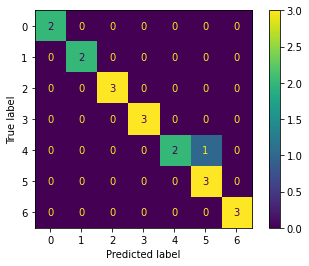

{'bending1': 0, 'bending2': 1, 'cycling': 2, 'lying': 3, 'sitting': 4, 'standing': 5, 'walking': 6}


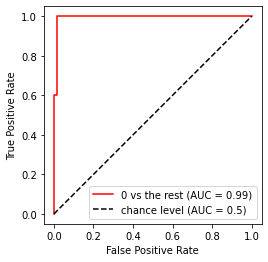

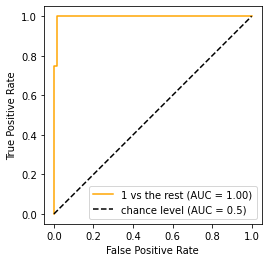

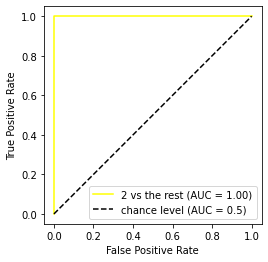

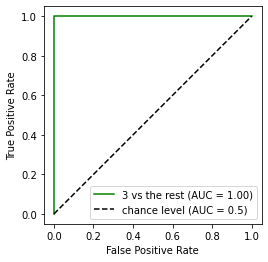

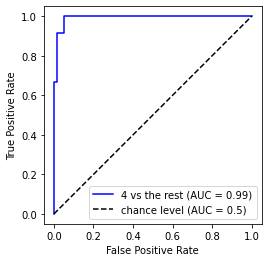

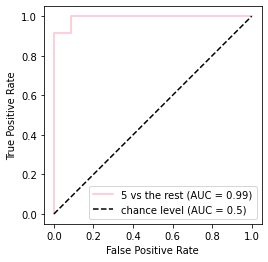

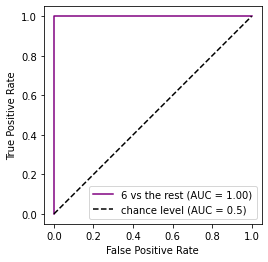

Area Under the Curve for Train set:  0.9962602821155453
Accuracy Score for Gaussian Naive Bayes :  0.9473684210526315


In [81]:
print("Accuracy Score for Gaussian Naive Bayes : ",testNaiveBayes(MultinomialNB(),best_l_val_mn))

In [91]:
print("Test Error for Multinomial Naive Bayes will be :",1-mn_test_accuracy)

Test Error for Multinomial Naive Bayes will be : 0.052631578947368474


In [82]:
accuracy_table.add_row(["GaussianNB for Multiclass",str(nb_train_accuracy*100),str(nb_test_accuracy*100)])
accuracy_table.add_row(["MultinomialNB for Multiclass",str(mn_train_accuracy*100),str(mn_test_accuracy*100)])

In [83]:
print("Best value for L with associated number of features : ")
print(table)

Best value for L with associated number of features : 
+----------------------------+--------------+--------------+
|            Task            | Best L Value | Best P value |
+----------------------------+--------------+--------------+
| 2-A-iii(Before Resampling) |      5       |      9       |
|      After Resampling      |      2       |      3       |
+----------------------------+--------------+--------------+


In [84]:
print("Best Value for L and associated C for Logistic Regression with l1 penalty :")
print(table1)

Best Value for L and associated C for Logistic Regression with l1 penalty :
+------------------------------------------------+------------------+-------------------------------+
|                      Task                      | Best Value for L | Value for C associated with L |
+------------------------------------------------+------------------+-------------------------------+
|      Logistic Regression with L1 Penalty       |        4         |       1291.5496650148827      |
| Multiclass Logistic Regression with L1 Penalty |        1         |       21.54434690031882       |
+------------------------------------------------+------------------+-------------------------------+


In [85]:
print("Best Value of L for Gaussian and Multinomial NB :")
print(table2)

Best Value of L for Gaussian and Multinomial NB :
+----------------+-------------+
|      Task      | Value for l |
+----------------+-------------+
|  Gaussian NB   |      7      |
| Multinomial NB |      5      |
+----------------+-------------+


In [86]:
print("Summary of Accuracies on Training and Testing data :")
print(accuracy_table)

Summary of Accuracies on Training and Testing data :
+--------------------------------------------------------------------+-------------------+-------------------+
|                               Model                                | Training Accuracy |  Testing Accuracy |
+--------------------------------------------------------------------+-------------------+-------------------+
|        Logistic Regression with Backward Feature Selection         |       100.0       | 94.73684210526315 |
| Logistic Regression with Resampling and Backward Feature Selection |       100.0       | 94.73684210526315 |
|     Logistic Regression with L1 Penalty and Feature Selection      |       100.0       |       100.0       |
|                 Logistic Regression for Multiclass                 | 94.20289855072464 | 89.47368421052632 |
|                     GaussianNB for Multiclass                      | 98.55072463768117 | 84.21052631578947 |
|                    MultinomialNB for Multiclass          

### iii) Which method is better for multi-class classification in this problem?

<p><i>Ans. </i>Based on the features I have selected(Mean, Max and 3rd Quartile), Multinomial Naive Bayes is giving me the best results on the Testing Data with 94.73% Accuracy and 0.9962 Area under the curve. The values for optimal Logistic Regression model is 89.47% and 0.994 respectively.</p>


# 3. ISLR, 4.8.3

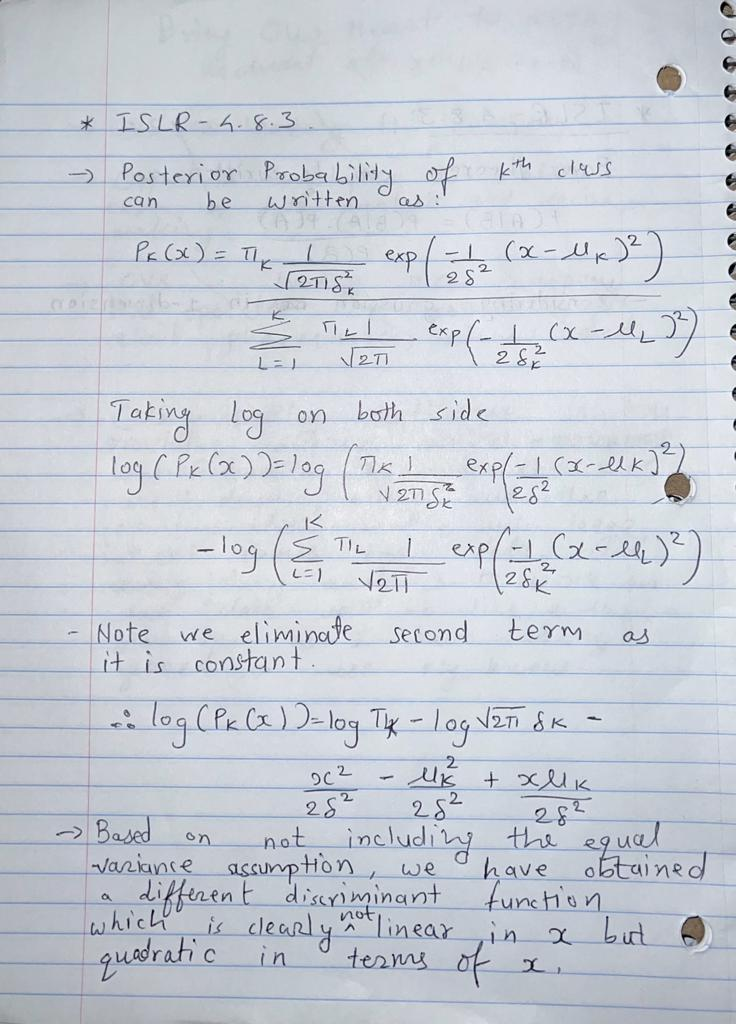

# 4. ISLR 4.8.7

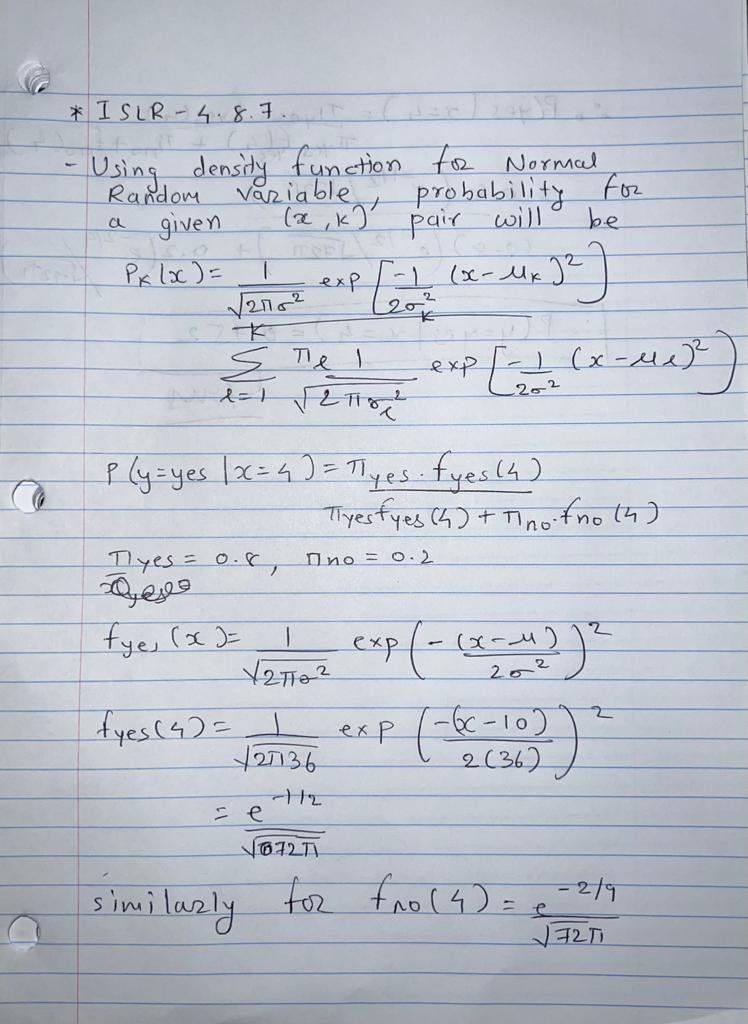

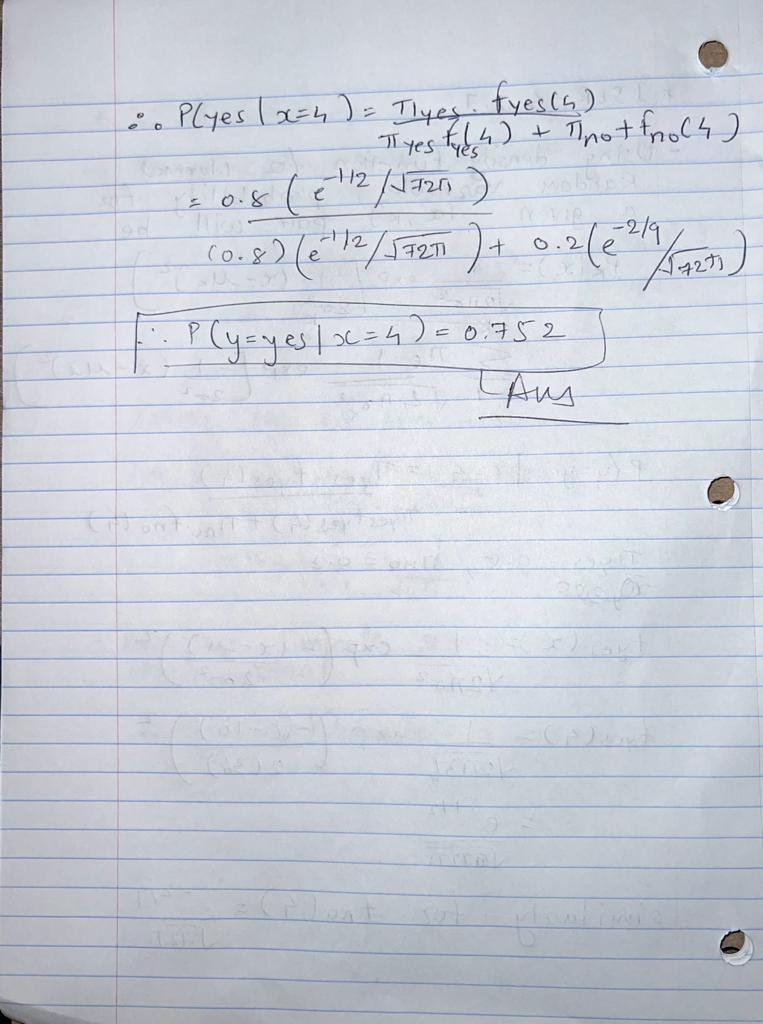